In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt


import hydra
from typing import Optional
from collections.abc import Callable
from omegaconf import OmegaConf, DictConfig

from data_module.lightning_data_module import DataModule
from hydra import initialize, initialize_config_module, initialize_config_dir, compose

In [2]:

def setup(cfg):

    cfg.loader.batch_size = 1

    if 'split' not in cfg:
        cfg.split = 'val'

    if 'shuffle' not in cfg:
        cfg.shuffle = False
        
def setup_config(cfg: DictConfig, override: Optional[Callable] = None):

    OmegaConf.set_struct(cfg, False)
    OmegaConf.resolve(cfg)
    OmegaConf.set_struct(cfg, True)


def merge_rgbs(imgs):

    fl = np.transpose(imgs[0], (1,2,0))
    ff = np.transpose(imgs[1], (1,2,0))
    fr = np.transpose(imgs[2], (1,2,0))

    front = np.hstack([fl, ff, fr])

    bl = np.transpose(imgs[5], (1,2,0))
    bf = np.transpose(imgs[4], (1,2,0))
    br = np.transpose(imgs[3], (1,2,0))

    back = np.hstack([bl, bf, br])

    whole = np.vstack([front, back])

    return whole

In [3]:

# *  config setup  * #
CONFIG_PATH = '/usr/src/CV_For_Autonomous_Driving/config'

with initialize_config_dir(config_dir=CONFIG_PATH):
    cfg = compose(config_name='default_config.yaml')
    
setup_config(cfg, setup)


# dataset list 만드는 test
DM = DataModule(cfg.data, cfg.loader)

split = 'val'
data_cfg = DM.data_cfg
datasets = DM.get_data(split=split,
                            **data_cfg)

# datasets = DM.get_dataset_bevdepth(split=split,
#                             **data_cfg)

print(f'In {split} dataset, {len(datasets)} scenes are included.')


# dataset init test
# total = 0
# for dataset in datasets:
#     total += len(dataset)

# print(f'nuscenes train has {total} data samples')


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  after removing the cwd from sys.path.
/opt/conda/lib/python3.7/site-packages/hydra/_internal/defaults_list.py:251: UserWarning: In 'default_config.yaml': Defaults list is missing `_self_`. See https://hydra.cc/docs/1.2/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)


Loading NuScenes tables for version v1.0-trainval...
23 category,
8 attribute,
4 visibility,
64386 instance,
12 sensor,
10200 calibrated_sensor,
2631083 ego_pose,
68 log,
850 scene,
34149 sample,
2631083 sample_data,
1166187 sample_annotation,
4 map,
Done loading in 37.634 seconds.
Reverse indexing ...
Done reverse indexing in 14.8 seconds.
In val dataset, 150 scenes are included.


In [5]:
# dataset __getitem__ test
data = datasets[0].__getitem__(0) #! Dataset output LIST 임
for k, v in data.items():
    print(f'{k}: {v.shape}')

depth: torch.Size([6, 224, 480])
cam_idx: torch.Size([6])
image: torch.Size([6, 3, 224, 480])
intrinsics: torch.Size([6, 3, 3])
extrinsics: torch.Size([6, 4, 4])
bev: torch.Size([12, 200, 200])
view: torch.Size([3, 3])
center: torch.Size([1, 200, 200])
visibility: torch.Size([200, 200])
gt_box: torch.Size([37, 9])
gt_label: torch.Size([37])


### Visualization: depth ground truth

[ 3.25820494  3.26463294  3.26664495 ... 80.54252625 81.51017761
 82.51567078]


(-0.5, 1599.5, 899.5, -0.5)

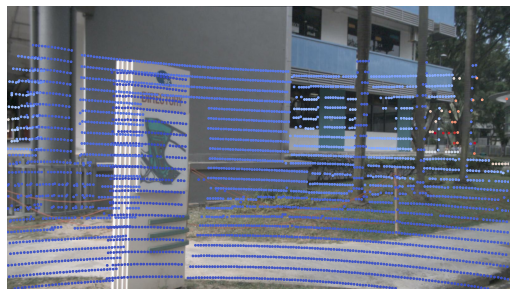

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(9, 16))

# fig.canvas.set_window_title(sample_token)
img = np.transpose(data['image'][0].numpy(), (1,2,0))
depth = data['depth'][0].numpy()
# debug_d = data['debug_d'][0]

h, w = depth.shape

x = np.linspace(0, w, w)
y = np.linspace(0, h, h)
xs, ys = np.meshgrid(x, y)

xs_flat = xs.flatten()
ys_flat = ys.flatten()
depth_flat = depth.flatten()

mask = depth_flat > 1e-5
xs_filter = xs_flat[mask]
ys_filter = ys_flat[mask]
depth_filter = depth_flat[mask]

print(np.unique(depth_filter))

ax.imshow(img)
ax.scatter(xs_filter, ys_filter, c=depth_filter, s=3, cmap='coolwarm') 


ax.axis('off')

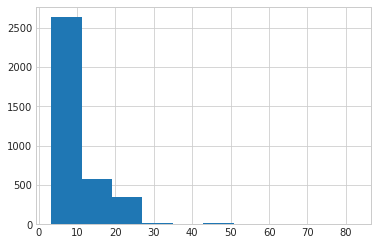

In [ ]:
plt.hist(depth_filter)
plt.show()

### Visualization: 3d bbox ground truth

In [ ]:
def vis_gt(bev):
    # bev = np.transpose(bev, (1, 2, 0))
    area = bev[:,:,0] + bev[:,:,1]
    divider = bev[:,:,2] + bev[:,:,3]
    vehicle = bev[:,:,4] + bev[:,:,5] + bev[:,:,6] + bev[:,:,7]

    h, w = area.shape
    vis = np.full((h, w, 3), 255, dtype='uint8')

    
    for i, bibev in enumerate([area, divider, vehicle]):
    # for i, bibev in enumerate([area, vehicle]):
        vis[bibev!=0,:] = mapping[i]
    
    vis[95:105, 98:102, :] = (255, 0, 0)

    return vis

In [ ]:
# 3d bbox 
mapping = {0: (255, 153, 51),
            1: (0, 128, 255),
            2: (0, 0, 255)}

bev_map = np.full((200, 200, 3), 255)

gt_bbox = data['gt_box'].numpy()
gt_cls = data['gt_label'].numpy()

In [ ]:
# merge images
merged_imgs = merge_rgbs(data['image'].numpy())
# bev: torch.Size([200, 200, 12])
bev = vis_gt(data['bev'].numpy())

In [ ]:
cls_mapping = {}
for i in range(10):
    cls_mapping[i] = np.random.rand((3))*255

In [ ]:
from data_module.dataset.utils import *

bev_cfg = {'h': 200, 'w': 200, 
                    'h_meters': 100.0, 'w_meters': 100.0, 'offset': 0.0}
meter2pix = get_bev_meter2pix_matrix(bev_cfg)

In [ ]:
xy = gt_bbox[:,:2]
z = np.ones(gt_bbox.shape[0])[:,None]
xy1 = np.concatenate([xy,z], 1)
img_xy1 = np.matmul(meter2pix, xy1.T).T

In [ ]:
# x_start = (gt_bbox[:,1] - (gt_bbox[:,4]/2)) + 50
# x_end = (gt_bbox[:,1] + (gt_bbox[:,4]/2)) + 50

# y_start = (gt_bbox[:,0] - (gt_bbox[:,3]/2)) + 50
# y_end = (gt_bbox[:,0] + (gt_bbox[:,3]/2)) + 50


x_start = (img_xy1[:,0] - (gt_bbox[:,3]))
x_end = (img_xy1[:,0] + (gt_bbox[:,3]))

y_start = (img_xy1[:,1] - (gt_bbox[:,4]))
y_end = (img_xy1[:,1] + (gt_bbox[:,4]))


for i in range(gt_bbox.shape[0]):
    if (x_start[i] < 0 or x_start[i] > 200) or (x_end[i] < 0 or x_end[i] > 200) \
        or (y_start[i] < 0 or y_start[i] > 200) or (y_end[i] < 0 or y_end[i] > 200):
        continue
    x = np.linspace(int(x_start[i]), int(x_end[i])-1, int(x_end[i])-int(x_start[i]))
    y = np.linspace(int(y_start[i]), int(y_end[i])-1, int(y_end[i])-int(y_start[i]))
    xs, ys = np.meshgrid(x, y)
    
    xs = np.asarray(xs, dtype=int)
    ys = np.asarray(ys, dtype=int)

    # print(xs.shape)
    xy = np.stack([xs.flatten(), ys.flatten()]) # 2 n
    # # print(xy.shape)
    yaw = gt_bbox[i,6] / 180 * np.pi
    rot = np.array([[np.cos(yaw), np.sin(yaw)],
                    [-np.sin(yaw), np.cos(yaw)]])

    rotated_xy = np.asarray(np.matmul(rot, xy), dtype=int)

    # # # xy = np.asarray(xy, dtype=int)

    bev_map[rotated_xy[0], rotated_xy[1], :] = cls_mapping[gt_cls[i]]

    # bev_map[rotated_xy] = cls_mapping[gt_cls[i]]

    # bev_map[int(y_start[i]):int(y_end[i]), int(x_start[i]):int(x_end[i]), :] = cls_mapping[gt_cls[i]]
    # bev_map[int(x_start[i]):int(x_end[i]), int(y_start[i]):int(y_end[i]), :] = cls_mapping[gt_cls[i]]

(-0.5, 199.5, 199.5, -0.5)

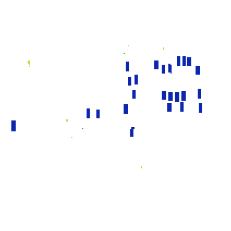

In [ ]:
plt.imshow(bev_map)
plt.axis('off')

(-0.5, 199.5, 199.5, -0.5)

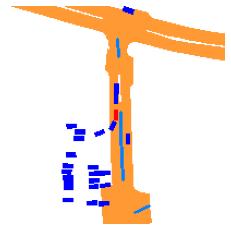

In [ ]:
plt.imshow(bev)
plt.axis('off')

(-0.5, 4799.5, 1799.5, -0.5)

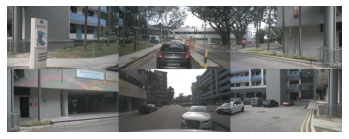

In [ ]:
plt.imshow(merged_imgs)
plt.axis('off')